<a href="https://colab.research.google.com/github/hbaflast/bert-sentiment-analysis-tensorflow/blob/master/bert_sentiment_analysis_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bert Sentiment Analysis - TensorFlow

## Import

In [0]:
# Install missing librairies
!pip install transformers
# Switch to tf2 (Colab run tensorflow 1.X by default for the moment)
%tensorflow_version 2.x

In [0]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from datetime import datetime
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, Input

from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import (BertTokenizer, BertForSequenceClassification, TFBertForSequenceClassification,
                          CamembertTokenizer, CamembertForSequenceClassification, TFCamembertForSequenceClassification)

In [0]:
plt.rcParams["figure.figsize"] = (16, 9)

In [4]:
# check gpu
!nvidia-smi

Fri Feb 21 12:07:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Load data

### Kaggle creadentials

In [0]:
# enter your Kaggle credentionals here
os.environ['KAGGLE_USERNAME'] = ""
os.environ['KAGGLE_KEY'] = ""

In [6]:
!kaggle datasets download hbaflast/french-twitter-sentiment-analysis

 97% 47.0M/48.3M [00:01<00:00, 25.4MB/s]
100% 48.3M/48.3M [00:01<00:00, 41.6MB/s]


### Read dataset

In [0]:
df_dataset = pd.read_csv("/content/french-twitter-sentiment-analysis.zip", sep=',')

In [0]:
df_dataset = df_dataset.sample(frac=0.1, random_state=42)  # sample to speed-up computation

In [9]:
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152672 entries, 471040 to 126980
Data columns (total 2 columns):
label    152672 non-null int64
text     152672 non-null object
dtypes: int64(1), object(1)
memory usage: 3.5+ MB


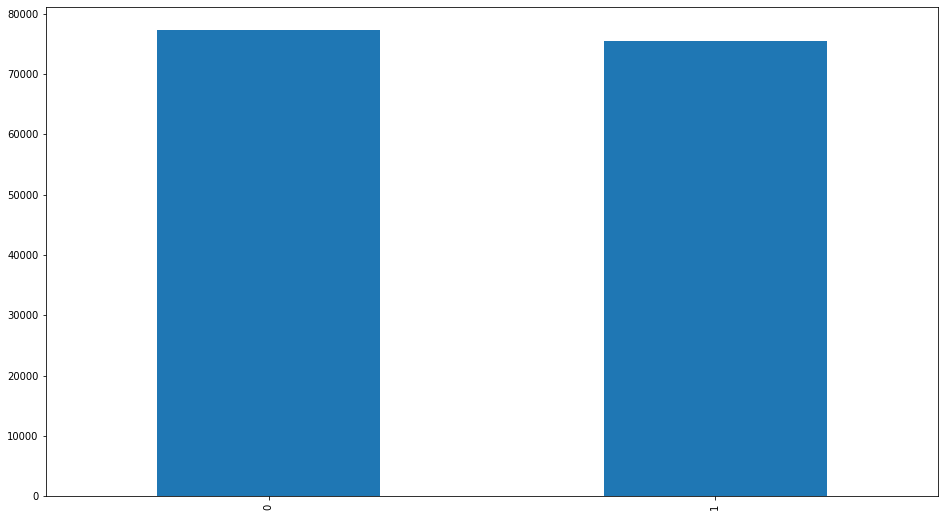

In [10]:
df_dataset['label'].value_counts().plot.bar();

## Text length distribution

In [11]:
df_dataset['sent_len'] = df_dataset['text'].apply(lambda x: len(x.split(" ")))
max_seq_len = np.round(df_dataset['sent_len'].mean() + 2 * df_dataset['sent_len'].std()).astype(int)
max_seq_len

30

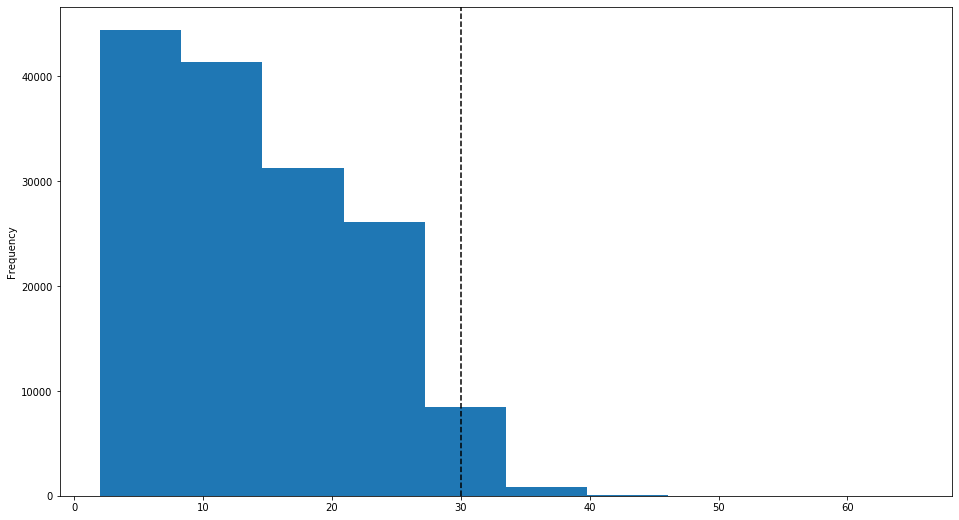

In [12]:
df_dataset['sent_len'].plot.hist()
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len');

## Load tokenizer

In [13]:
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

In [14]:
tokenizer.tokenize("J'aime bien faire des achats en ligne")

['▁J', "'", 'aime', '▁bien', '▁faire', '▁des', '▁achats', '▁en', '▁ligne']

In [15]:
tokenizer.encode("J'aime bien faire des achats en ligne")

[5, 121, 11, 660, 72, 85, 20, 5503, 22, 284, 6]

## Load transformers model

In [16]:
transformers_model = TFCamembertForSequenceClassification.from_pretrained('jplu/tf-camembert-base', num_labels=2)

In [17]:
transformers_model.summary()

Model: "tf_camembert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
roberta (TFRobertaMainLayer) multiple                  110621952 
_________________________________________________________________
classifier (TFRobertaClassif multiple                  592130    
Total params: 111,214,082
Trainable params: 111,214,082
Non-trainable params: 0
_________________________________________________________________


## Process imput example

In [18]:
input_ =  tf.expand_dims(tokenizer.encode("J'aime bien faire des achats en ligne"), 0)
input_

<tf.Tensor: shape=(1, 11), dtype=int32, numpy=
array([[   5,  121,   11,  660,   72,   85,   20, 5503,   22,  284,    6]],
      dtype=int32)>

In [19]:
att_mask = tf.expand_dims(np.ones(input_.shape[1], dtype='int32'), 0)
att_mask

<tf.Tensor: shape=(1, 11), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>

In [20]:
logits = transformers_model([input_, att_mask])
logits

(<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.00738625,  0.01448394]], dtype=float32)>,)

## Pre-processing

### Tokenize text & padding

In [21]:
df_dataset.head()

,label,text,sent_len
471040,0,El som et la société humaine avec cindy! Je ve...,16
1340507,1,Quel beau jour d'été,4
757669,0,Déteste assis à l'intérieur quand c'est une be...,9
119639,0,Lundi matin même pas le soleil,6
1190949,1,La soeur a juste été bronzée: soph: 'what are ...,23


In [22]:
input_sequences = []
# The attention mask is an optional argument used when batching sequences together.
# The attention mask is a binary tensor indicating the position of the padded indices so that the model does not attend to them.
attention_masks = []

for text in tqdm_notebook(df_dataset['text']):
    sequence_dict = tokenizer.encode_plus(text, max_length=max_seq_len, pad_to_max_length=True)
    input_ids = sequence_dict['input_ids']
    att_mask = sequence_dict['attention_mask']

    input_sequences.append(input_ids)
    attention_masks.append(att_mask)

In [23]:
print(input_sequences[0])
print(attention_masks[0])

[5, 1595, 52, 3081, 14, 13, 426, 2095, 42, 60, 3778, 105, 152, 100, 920, 302, 23, 14518, 47, 23, 16060, 6, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]


In [0]:
labels = df_dataset['label'].values

In [25]:
print(labels[0])

0


## Train Test Split

In [0]:
X_train, X_test, y_train, y_test, att_masks_train, att_masks_test = (
    train_test_split(input_sequences, labels, attention_masks, random_state=42, test_size=0.2)
)

In [0]:
X_train = tf.constant(X_train)
X_test = tf.constant(X_test)

y_train = tf.constant(y_train)
y_test = tf.constant(y_test)

att_masks_train = tf.constant(att_masks_train)
att_masks_test = tf.constant(att_masks_test)

In [28]:
print(f'Train | X shape: {X_train.shape}, att_mask shape: {att_masks_train.shape}, y shape: {y_train.shape}')
print(f'Test | X shape: {X_test.shape}, att_mask shape: {att_masks_test.shape}, y shape: {y_test.shape},')

Train | X shape: (122137, 30), att_mask shape: (122137, 30), y shape: (122137,)
Test | X shape: (30535, 30), att_mask shape: (30535, 30), y shape: (30535,),


## Create model

In [0]:
def create_model():
    model = TFCamembertForSequenceClassification.from_pretrained('jplu/tf-camembert-base', num_labels=2)
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    opt = tf.keras.optimizers.Adam(lr=2e-5)
  
    model.compile(loss=loss,
                  optimizer=opt,
                  metrics=['accuracy'])
  
    return model

In [30]:
model = create_model()
model.summary()

Model: "tf_camembert_for_sequence_classification_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
roberta (TFRobertaMainLayer) multiple                  110621952 
_________________________________________________________________
classifier (TFRobertaClassif multiple                  592130    
Total params: 111,214,082
Trainable params: 111,214,082
Non-trainable params: 0
_________________________________________________________________


## Training

In [31]:
loss, metric = model.evaluate([X_test, att_masks_test], y_test, batch_size=32, verbose=0)
print(f"Loss before training: {loss:.4f}, Accuracy before training: {metric:.2%}")

Loss before training: 0.6932, Accuracy before training: 49.87%


In [32]:
history = model.fit([X_train, att_masks_train], y_train, batch_size=32, epochs=2, validation_data=([X_test, att_masks_test], y_test))

Train on 122137 samples, validate on 30535 samples
Epoch 1/2
122137/122137 [==============================] - 624s 5ms/sample - loss: 0.4372 - accuracy: 0.7967 - val_loss: 0.4157 - val_accuracy: 0.8107
Epoch 2/2
122137/122137 [==============================] - 610s 5ms/sample - loss: 0.3717 - accuracy: 0.8361 - val_loss: 0.4096 - val_accuracy: 0.8201


## Test model on new sentences

In [0]:
def predict(text):
    # pre-process text
    encoded_text = tokenizer.encode(text)

    input_ = tf.expand_dims(encoded_text, 0)

    logits = model(input_)[0][0]
    pred = tf.nn.softmax(logits).numpy()
    
    return pred

In [0]:
text = "Qu'est c'que c'est trop beau la vie d'artiste"

In [35]:
predict(text)

array([0.02004558, 0.9799544 ], dtype=float32)

In [0]:
text = "Je n'aime pas faire la vaisselle"

In [37]:
predict(text)

array([0.9884135 , 0.01158649], dtype=float32)

## Save model


In [0]:
save_path = "finetuned-model"

In [0]:
os.mkdir(save_path)

In [0]:
model.save_pretrained(save_path)